In [ ]:
#the idea and implementation of the processing of data for LSTM was adapted from the keras IMDB dataset:
'''
***************************************************************************************/
*    Title: IMDB movie review sentiment classification dataset
*    Author: -
*    Date: -
*    Availability: https://keras.io/api/datasets/imdb/
*
***************************************************************************************/
'''
#importing of packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.utils import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras import losses
import matplotlib.pyplot as plt
from sklearn import metrics
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import random
import math
import string
import csv
!wget https://raw.githubusercontent.com/lee1613/Sentiment-Analysis-NLP-/main/dataset.csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2023-04-01 12:36:03--  https://raw.githubusercontent.com/lee1613/Sentiment-Analysis-NLP-/main/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1273144 (1.2M) [text/plain]
Saving to: ‘dataset.csv.1’

dataset.csv.1       100%[===================>]   1.21M  --.-KB/s    in 0.04s   

2023-04-01 12:36:03 (33.7 MB/s) - ‘dataset.csv.1’ saved [1273144/1273144]



In [ ]:
#loading of dataset here
with open("dataset.csv") as f: 
    reader = csv.reader(f,delimiter = ",")
    labels  = []
    comments = []
    counter = 0
    for line in reader:
        labels += line[0]
        comments += [line[1]]

comments = np.array(comments) #sentences
labels = np.array(labels) #labels for each sentence
print(comments.size, labels.size)
print(comments[21])


10662 10662
with a cast that includes some of the top actors working in independent film , lovely & amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives .


In [ ]:
#preprocessing of data: no punctuations/special characters/fluff words
for i, sen in enumerate(comments):
  comments[i] = sen.lower() #set sentences to lowercase
stopwords = stopwords.words('english')
special_chars = ["!",'"',"%","&","'","(",")", "*","+",",","-",".",
                  "/",":",";","<","=",">","?","[","\\","]","^","_",
                  "`","{","|","}","~","–","@","#","$"]
for i, sen in enumerate(comments):
  temp = ''
  for word in sen.split():
    if word not in stopwords and word not in special_chars: #removes stopwords and special characters
      temp = temp + ' ' + word #appends the remaining words together
  comments[i] = temp

print(comments)

[" rock destined 21st century's new conan he's going make splash even greater arnold schwarzenegger jean-claud van damme steven segal"
 " gorgeously elaborate continuation lord rings trilogy huge column words cannot adequately describe co-writer/director peter jackson's expanded vision j r r tolkien's middle-earth"
 ' effective too-tepid biopic' ...
 " stands crocodile hunter hurried badly cobbled look 1959 godzilla combined scenes japanese monster flick canned shots raymond burr commenting monster's path destruction"
 ' thing looks like made-for-home-video quickie'
 ' enigma well-made dry placid']


In [ ]:
#counting all unique words, and puts them into an ordered list based on occurrence
top_words = {}
total = 0
for sentence in comments:
  words = sentence.split()
  for word in words:
    if top_words.get(word):
      top_words[word] += 1
      total+= 1
    elif word not in string.punctuation:
      top_words[word] = 1
      total += 1
top_words = sorted(top_words.items(), key=lambda x:x[1])[::-1] #sorts words based on occurrence
top_words = np.array(top_words)[:, 0]
print(top_words, top_words.size)

['film' 'movie' 'one' ... 'segal' 'jean-claud' "century's"] 21221


In [ ]:
#turning all sentences into indexed version based on how often they occur in sentences (top_words).
temp = []
indexed_comments = []
for sentence in comments:
  words = sentence.split()
  for word in words:
    if word not in string.punctuation and word not in stopwords:
      index = np.where(top_words==word)[0][0] #searches for index of word in top_words and appends it
      temp.append(index+1)
  temp = np.asarray(temp)
  indexed_comments.append(temp)
  temp = []
print(indexed_comments[5000], total)

[4856 2775    4 1354 2897  942  805 1987 3449  579  157] 113253


In [ ]:
# processing the data and prepared it for the training of the model
labels  = labels.astype(int) #converting y arrays to int
a = list(map(len,indexed_comments))
max_sentence_length = max(a)
print(max_sentence_length)
indexed_comments = pad_sequences(indexed_comments,maxlen = max_sentence_length)#padding sentences for input into LSTM
print(indexed_comments[1], type(indexed_comments))

39
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0  3600  2125 10210  5293  3069  5292   988
 10209   670   739  5291  2680 10208  1039  6972  5290   544  1178  3068
  3068 10207 21218] <class 'numpy.ndarray'>


In [21]:
# splitting the data sets into k proportion of the training datasets and the rest as testing dataset k is adjusttable
n = len(indexed_comments)
training_n = int(n*.8)
testing_n = n - training_n
list_of_indices = np.arange(0,n)
np.random.seed(0) #setting the seed to make data randomization across the board the same, can comment out and run to check for consistency in model
np.random.shuffle(list_of_indices) #randomly shuffles all data
training_indices =list_of_indices[:training_n]
testing_indices = list_of_indices[training_n:]
train_x = np.array([indexed_comments[i] for i in training_indices])
train_y = np.array([labels[i] for i in training_indices])
test_x = np.array([indexed_comments[i] for i in testing_indices])
test_y = np.array([labels[i] for i in testing_indices])
print(train_x.shape,train_y.size,test_x.shape, test_y.size)

(8529, 39) 8529 (2133, 39) 2133


In [22]:
# initializing LSTM algo
opt = Adam(learning_rate = 0.001)
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(len(top_words)+1, embedding_vector_length, input_length = max_sentence_length))
model.add(LSTM(100))
model.add(Dropout(.6))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 32)            679104    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 732,405
Trainable params: 732,405
Non-trainable params: 0
_________________________________________________________________


In [23]:
#running algo to train the dataset using different dataset
data = model.fit(train_x, train_y, epochs = 3, batch_size = 64, validation_data = (test_x,test_y))


Epoch 1/3
134/134 [==============================] - 21s 103ms/step - loss: 0.6533 - accuracy: 0.6082 - val_loss: 0.5444 - val_accuracy: 0.7403
Epoch 2/3
134/134 [==============================] - 12s 91ms/step - loss: 0.3700 - accuracy: 0.8472 - val_loss: 0.5124 - val_accuracy: 0.7459
Epoch 3/3
134/134 [==============================] - 12s 92ms/step - loss: 0.1711 - accuracy: 0.9414 - val_loss: 0.5753 - val_accuracy: 0.7496


67/67 [==============================] - 1s 13ms/step
[[778 265]
 [269 821]]


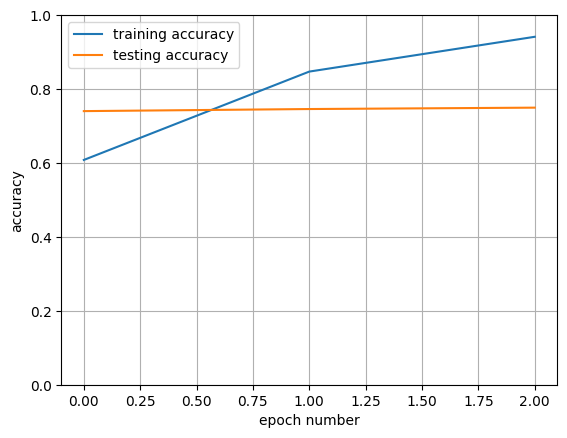

Accuracy = 74.96%
F1 score = 75.46%
Precision = 75.60%
Recall = 75.32%


In [24]:
#plots out the training and testing accuracy at each epoch of the training phase
history = data.history
test_predict = model.predict(test_x)
test_predict = np.array([1 if result >= .5 else 0 for result in test_predict])
#prints confusion matrix
result = confusion_matrix(test_y,test_predict)
print(result)
### Training Accuracy Graph
plt.plot(history["accuracy"], label = ('training accuracy'))
plt.plot(history["val_accuracy"], label = ('testing accuracy'))
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0,1)
plt.grid()

plt.show()
#prints metrics
print(f"Accuracy = {metrics.accuracy_score(test_y,test_predict)*100:.2f}%")
print(f"F1 score = {metrics.f1_score(test_y,test_predict)*100:.2f}%")
print(f"Precision = {metrics.precision_score(test_y,test_predict)*100:.2f}%")
print(f"Recall = {metrics.recall_score(test_y,test_predict)*100:.2f}%")

In [25]:
#function that converts a sentence to numbers based on the ordered list to facilitate manual checking of certain words
def string_to_num(txt):
  sentence = []
  count = 1
  words = txt.split()
  for word in words:
    if word not in string.punctuation:
      if np.where(top_words==word)[0]:
        sentence.append(np.where(top_words==word)[0][0]+1)
      else:
        sentence.append(top_words.size+count)
        count += 1
  return [np.array(sentence)]
  

In [ ]:
#the string can be replaced with a word to see what the model thinks the sentiment of the word is
word = "sucks"
model.predict(pad_sequences(string_to_num(word), maxlen = max_sentence_length)) 

1/1 [==============================] - 0s 96ms/step


array([[0.95805377]], dtype=float32)